##### Load the Required Libraries 

In [1]:
from tensorflow.contrib import learn
import tensorflow as tf

/Users/i033085/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [2]:
from sklearn import linear_model
from sklearn import metrics

In [3]:
import numpy as np 
import pandas as pd 
import scipy

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn import model_selection, preprocessing
import datetime

In [5]:
import keras as ks
from keras.models import Sequential, load_model, Model
from keras.preprocessing import sequence
from keras.optimizers import SGD, RMSprop
from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding
from keras.wrappers.scikit_learn import KerasRegressor

Using TensorFlow backend.


In [6]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import KFold, ParameterGrid, cross_val_score
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor

##### Get a feel of the Data volumes

In [7]:
macro = pd.read_csv('data/macro.csv')
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [8]:
macro.shape

(2484, 100)

In [9]:
train.shape

(30471, 292)

In [10]:
test.shape

(7662, 291)

In [11]:
# Lets move on ignoring the Macro-Economic attributes ...and revisit later

In [12]:
train.describe()

,id,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
count,30471.000000,30471.000000,24088.000000,30304.000000,20899.000000,20899.000000,16866.000000,20899.000000,20899.000000,16912.000000,...,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,30471.000000,3.047100e+04
mean,15237.917397,54.214269,34.403271,7.670803,12.558974,1.827121,3068.057097,1.909804,6.399301,2.107025,...,32.058318,10.783860,1.771783,15.045552,30.251518,0.442421,8.648814,52.796593,5.987070,7.123035e+06
std,8796.501536,38.031487,52.285733,5.319989,6.756550,1.481154,154387.795637,0.851805,28.265979,0.880148,...,73.465611,28.385679,5.418807,29.118668,47.347938,0.609269,20.580741,46.292660,4.889219,4.780111e+06
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+05
25%,7620.500000,38.000000,20.000000,3.000000,9.000000,1.000000,1967.000000,1.000000,1.000000,1.000000,...,2.000000,1.000000,0.000000,2.000000,9.000000,0.000000,0.000000,11.000000,1.000000,4.740002e+06
50%,15238.000000,49.000000,30.000000,6.500000,12.000000,1.000000,1979.000000,2.000000,6.000000,2.000000,...,8.000000,2.000000,0.000000,7.000000,16.000000,0.000000,2.000000,48.000000,5.000000,6.274411e+06
75%,22855.500000,63.000000,43.000000,11.000000,17.000000,2.000000,2005.000000,2.000000,9.000000,3.000000,...,21.000000,5.000000,1.000000,12.000000,28.000000,1.000000,7.000000,76.000000,10.000000,8.300000e+06
max,30473.000000,5326.000000,7478.000000,77.000000,117.000000,6.000000,20052009.000000,19.000000,2014.000000,33.000000,...,377.000000,147.000000,30.000000,151.000000,250.000000,2.000000,106.000000,218.000000,21.000000,1.111111e+08


##### Data pre-processing .... 

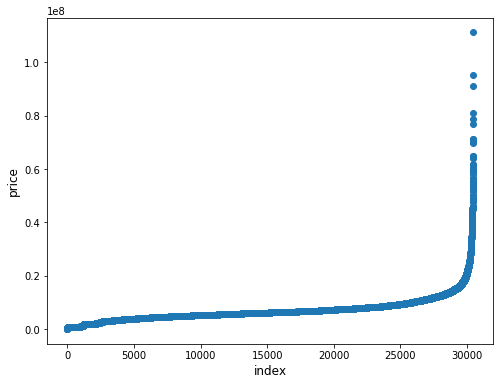

In [13]:
plt.figure(figsize=(8,6))
plt.scatter(range(train.shape[0]), np.sort(train.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

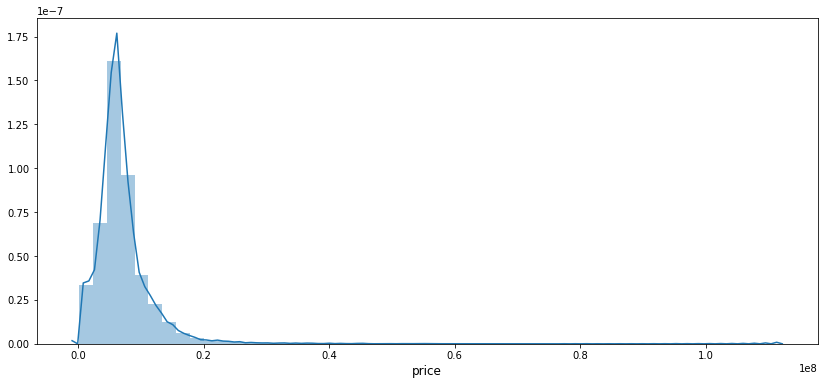

In [14]:
#We can now bin the 'price_doc' and plot it.
plt.figure(figsize=(14,6))
sns.distplot(train.price_doc.values, bins=50, kde=True)
plt.xlabel('price', fontsize=12)
plt.show()

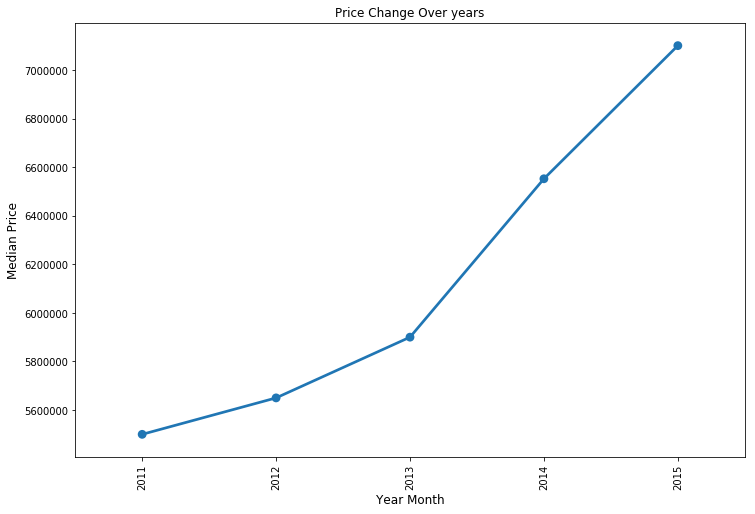

In [15]:
# Price Change Over years 
train_temp = train
train_temp['year'] = train['timestamp'].apply(lambda x: x[:4])
grouped_df = train_temp.groupby('year')['price_doc'].aggregate(np.median).reset_index()

plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.year.values, grouped_df.price_doc.values, alpha=0.8, color="#2076b4")
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Year Month', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Price Change Over years")
plt.show()

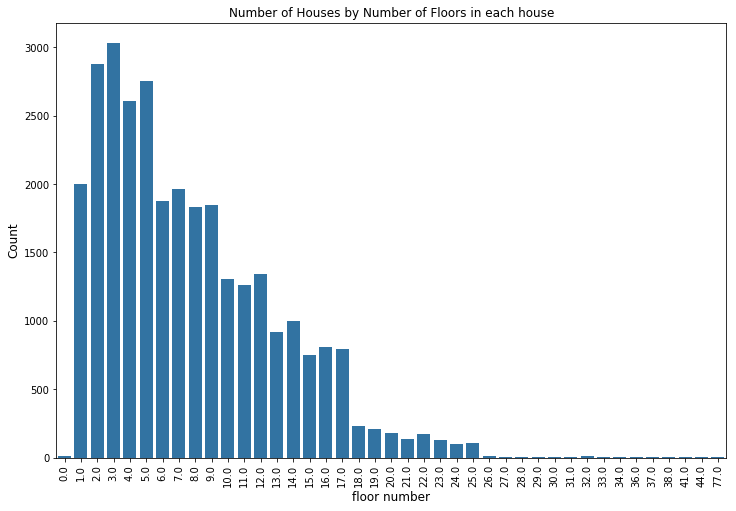

In [16]:
# Number of Houses by Number of Floors in each house
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train, color="#2076b4")
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.title("Number of Houses by Number of Floors in each house")
plt.xticks(rotation='vertical')
plt.show()

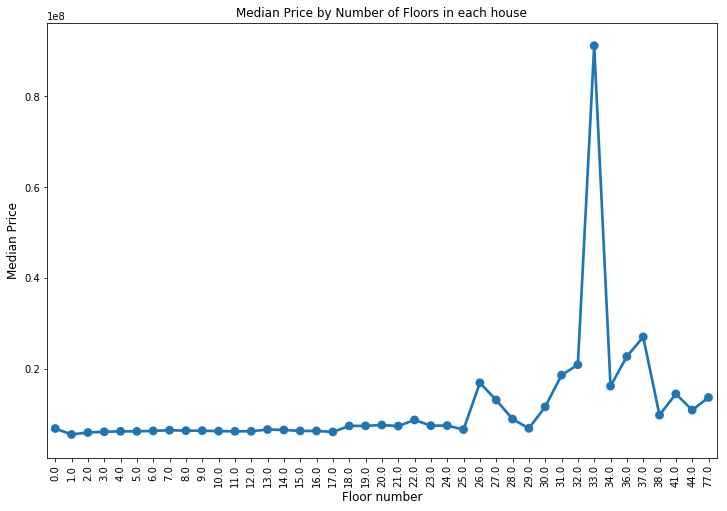

In [17]:
#Price change by Number of Floors in each house
grouped_df = train.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize=(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color="#2076b4")
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor number', fontsize=12)
plt.title("Median Price by Number of Floors in each house")
plt.xticks(rotation='vertical')
plt.show()

In [13]:
X_list_num = ['full_sq', 'num_room', 'floor', 'area_m', 
              'timestamp',
              'preschool_education_centers_raion', 'school_education_centers_raion', 
              'children_preschool', 'children_school',
              'shopping_centers_raion', 'healthcare_centers_raion', 
              'office_raion', 'sport_objects_raion',
              'public_transport_station_min_walk', 
              'railroad_station_walk_min', 'railroad_station_avto_km',
              'cafe_count_500',
              'kremlin_km', 'workplaces_km', 
              'ID_metro', 'metro_km_avto', 'metro_min_walk', 
              'public_healthcare_km', 'shopping_centers_km', 'big_market_km',
              'fitness_km', 'swim_pool_km', 'stadium_km', 'park_km',
              'kindergarten_km', 'school_km', 'preschool_km', 
              'university_km', 'additional_education_km',
              'theater_km', 'exhibition_km', 'museum_km', 
              'big_road1_km', 'big_road2_km',
              'detention_facility_km', 'cemetery_km', 'oil_chemistry_km', 'radiation_km',
              'raion_popul', 'work_all', 'young_all', 'ekder_all']
X_list_cat = ['sub_area', 'ecology', 'big_market_raion']

features_train = train[X_list_num]
features_test = test[X_list_num]
target_train = train['price_doc']

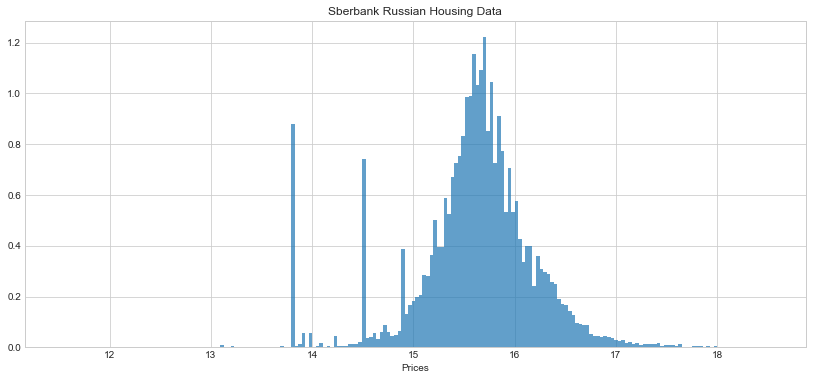

In [14]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(14, 6))

plt.hist(np.log(target_train), bins=200, normed=True, alpha=0.7)

plt.xlabel("Prices")
plt.title('Sberbank Russian Housing Data');

In [15]:
print ("Sberbank Russian Housing Dataset Statistics: \n")
print ("Number of houses = ", len(target_train))
print ("Number of features = ", len(list(features_train.keys())))
print ("Minimum house price = ", np.min(target_train))
print ("Maximum house price = ", np.max(target_train))
print ("Mean house price = ", "%.2f" % np.mean(target_train))
print ("Median house price = ", "%.2f" % np.median(target_train))
print ("Standard deviation of house prices =", "%.2f" % np.std(target_train))

Sberbank Russian Housing Dataset Statistics: 

('Number of houses = ', 30471)
('Number of features = ', 47)
('Minimum house price = ', 100000)
('Maximum house price = ', 111111112)
('Mean house price = ', '7123035.28')
('Median house price = ', '6274411.00')
('Standard deviation of house prices =', '4780032.89')


In [16]:
df = pd.DataFrame(features_train, columns=X_list_num)
df['prices'] = target_train

df = df.dropna(subset=['num_room'])

df['metro_min_walk'] = df['metro_min_walk'].interpolate(method='linear')
features_test['metro_min_walk'] = features_test['metro_min_walk'].interpolate(method='linear')

df['railroad_station_walk_min'] = df['railroad_station_walk_min'].interpolate(method='linear')
features_test['railroad_station_walk_min'] = \
features_test['railroad_station_walk_min'].interpolate(method='linear')

df['floor'] = df['floor'].fillna(df['floor'].median())
len(df)

/Users/i033085/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/Users/i033085/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


20899

In [17]:
ID_metro_cat = pd.factorize(df['ID_metro'])
df['ID_metro'] = ID_metro_cat[0]

In [18]:
ID_metro_pairs = dict(zip(list(ID_metro_cat[1]), list(set(ID_metro_cat[0]))))
ID_metro_pairs[224] = 219
features_test['ID_metro'].replace(ID_metro_pairs,inplace=True)

/Users/i033085/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [19]:
usdrub_pairs = dict(zip(list(macro['timestamp']), list(macro['usdrub'])))

In [20]:
df['timestamp'].replace(usdrub_pairs,inplace=True)
features_test['timestamp'].replace(usdrub_pairs,inplace=True)

In [21]:
df.rename(columns={'timestamp' : 'usdrub'}, inplace=True)
features_test.rename(columns={'timestamp' : 'usdrub'}, inplace=True)

/Users/i033085/anaconda2/lib/python2.7/site-packages/pandas/core/frame.py:2697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)


In [22]:
pearson = df.corr(method='pearson')
corr_with_prices = pearson.ix[-1][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]]

full_sq                              0.593829
num_room                             0.476337
kremlin_km                          -0.290126
sport_objects_raion                  0.256412
ID_metro                             0.250502
stadium_km                          -0.238431
detention_facility_km               -0.233395
university_km                       -0.222964
theater_km                          -0.222873
workplaces_km                       -0.220889
swim_pool_km                        -0.220480
exhibition_km                       -0.212144
radiation_km                        -0.208256
museum_km                           -0.203846
park_km                             -0.201636
metro_min_walk                      -0.200058
fitness_km                          -0.197702
metro_km_avto                       -0.194751
school_education_centers_raion       0.193896
healthcare_centers_raion             0.185419
shopping_centers_km                 -0.182459
public_healthcare_km              

In [23]:
target_train = df['prices'].as_matrix()
features_train = df.drop('prices', 1).as_matrix()
features_test = features_test.as_matrix()

In [24]:
X_train, X_test, y_train, y_test = train_test_split(features_train[:-100], target_train[:-100], 
                                                    test_size = 0.2, random_state = 1)
X_train.shape, X_test.shape

((16639, 47), (4160, 47))

In [25]:
scale = RobustScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.transform(X_test)

In [26]:
##### Ir-respective of the steps above the code below should be generic ...giving me some scope to actually do 
#### some feature engineering later ...

###### Regression

In [27]:
def loss_plot(fit_history):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['loss'], label = 'train')
    plt.plot(fit_history.history['val_loss'], label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(14, 6))

    plt.plot(fit_history.history['mean_absolute_error'], label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'], label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error'); 

In [28]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(94, input_dim=47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(94, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.5))
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [29]:
mlp_model = mlp_model()

mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            nb_epoch=80, batch_size=16, verbose=0)

/Users/i033085/anaconda2/lib/python2.7/site-packages/keras/models.py:981: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


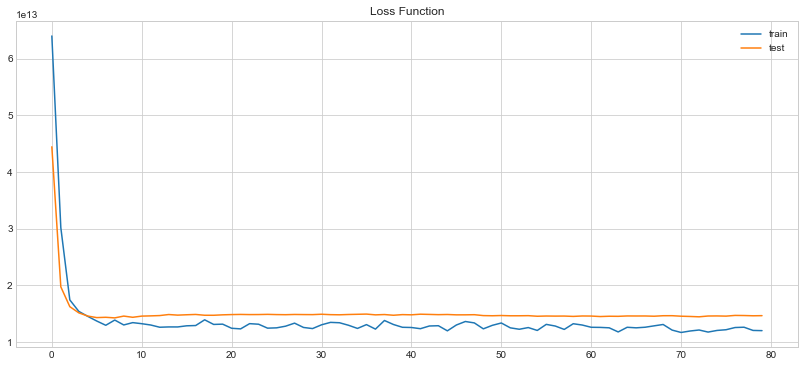

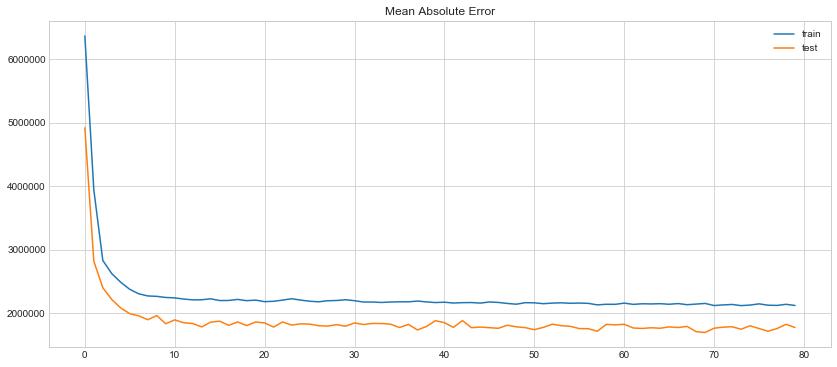

In [30]:
loss_plot(mlp_history)
mae_plot(mlp_history)

In [31]:
def mlp_model2():
    model = Sequential()
    
    model.add(Dense(188, input_dim=47, kernel_initializer='normal', activation='relu'))   
    model.add(Dense(188, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(94, kernel_initializer='normal', activation='relu'))  
    model.add(Dense(94, kernel_initializer='normal', activation='relu'))
    
    model.add(Dropout(0.2))
    
    model.add(Dense(47, kernel_initializer='normal', activation='relu'))
    
    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='rmsprop', metrics=['mae'])
    return model

In [32]:
mlp_model2 = mlp_model2()

mlp_history2 = mlp_model2.fit(X_train, y_train, validation_data=(X_test, y_test),
                            nb_epoch=80, batch_size=16, verbose=0)

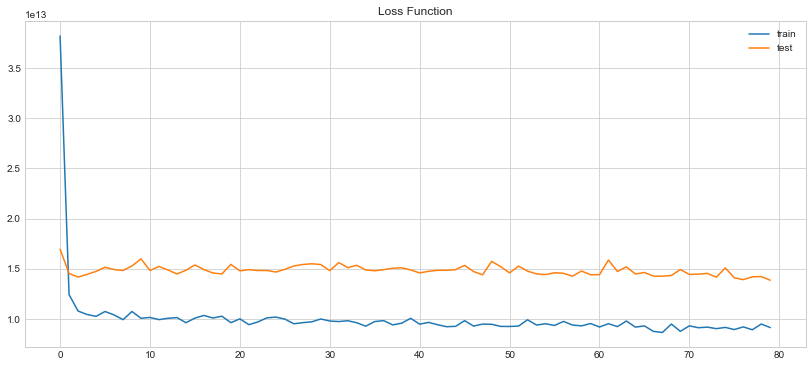

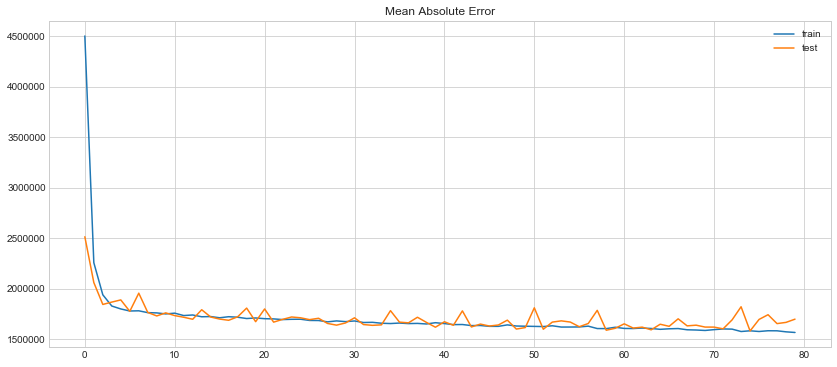

In [33]:
loss_plot(mlp_history2)
mae_plot(mlp_history2)

In [34]:
y_train_mlp = mlp_model.predict(X_train)
y_test_mlp = mlp_model.predict(X_test)

In [35]:
y_train_mlp2 = mlp_model2.predict(X_train)
y_test_mlp2 = mlp_model2.predict(X_test)

In [36]:
mlpr = MLPRegressor(hidden_layer_sizes=(188,), max_iter=200, solver='lbfgs', 
                    alpha=0.01, verbose=10)
mlpr.fit(X_train, y_train);

In [37]:
y_train_mlpr = mlpr.predict(X_train)
y_test_mlpr = mlpr.predict(X_test)

In [38]:
# TensorFlow Regression using DNN
features = learn.infer_real_valued_columns_from_input(X_train)

Instructions for updating:
Please specify feature columns explicitly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please access pandas data directly.
Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please convert numpy dtypes explicitly.
Instructions for updating:
Please specify feature columns explicitly.


In [39]:
# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build a multi-layer DNN for regression
model_nn = learn.DNNRegressor(feature_columns=features, hidden_units=[400, 200, 100], 
                              optimizer=adam, activation_fn=tf.nn.relu,
                              )



Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x119befe50>, '_model_dir': '/var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpb0HVDu', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master':

In [40]:
# Fit and predict
model_nn.fit(X_train, y_train, steps=15000, batch_size=512)


Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to the Estimator interface.
Instructions for up

INFO:tensorflow:global_step/sec: 168.24
INFO:tensorflow:loss = 6604483000000.0, step = 5001 (0.595 sec)
INFO:tensorflow:global_step/sec: 167.734
INFO:tensorflow:loss = 10919286000000.0, step = 5101 (0.596 sec)
INFO:tensorflow:global_step/sec: 164.62
INFO:tensorflow:loss = 7553219600000.0, step = 5201 (0.608 sec)
INFO:tensorflow:global_step/sec: 165.818
INFO:tensorflow:loss = 29383687000000.0, step = 5301 (0.603 sec)
INFO:tensorflow:global_step/sec: 169.219
INFO:tensorflow:loss = 6454808400000.0, step = 5401 (0.591 sec)
INFO:tensorflow:global_step/sec: 167.181
INFO:tensorflow:loss = 6648600000000.0, step = 5501 (0.598 sec)
INFO:tensorflow:global_step/sec: 168.931
INFO:tensorflow:loss = 7347326000000.0, step = 5601 (0.592 sec)
INFO:tensorflow:global_step/sec: 145.574
INFO:tensorflow:loss = 6710479600000.0, step = 5701 (0.686 sec)
INFO:tensorflow:global_step/sec: 158.184
INFO:tensorflow:loss = 7513809400000.0, step = 5801 (0.632 sec)
INFO:tensorflow:global_step/sec: 149.577
INFO:tensorflo

INFO:tensorflow:global_step/sec: 164.447
INFO:tensorflow:loss = 5756350000000.0, step = 12801 (0.607 sec)
INFO:tensorflow:global_step/sec: 152.095
INFO:tensorflow:loss = 7111610000000.0, step = 12901 (0.657 sec)
INFO:tensorflow:global_step/sec: 169.963
INFO:tensorflow:loss = 5059365600000.0, step = 13001 (0.589 sec)
INFO:tensorflow:global_step/sec: 166.292
INFO:tensorflow:loss = 8508493300000.0, step = 13101 (0.601 sec)
INFO:tensorflow:global_step/sec: 171.49
INFO:tensorflow:loss = 9127240000000.0, step = 13201 (0.584 sec)
INFO:tensorflow:global_step/sec: 158.437
INFO:tensorflow:loss = 5867336400000.0, step = 13301 (0.631 sec)
INFO:tensorflow:global_step/sec: 166.341
INFO:tensorflow:loss = 7853757700000.0, step = 13401 (0.602 sec)
INFO:tensorflow:global_step/sec: 167.853
INFO:tensorflow:loss = 8475297000000.0, step = 13501 (0.595 sec)
INFO:tensorflow:global_step/sec: 158.147
INFO:tensorflow:loss = 5820303500000.0, step = 13601 (0.633 sec)
INFO:tensorflow:global_step/sec: 161.425
INFO:t

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x11c094cd0>, 'hidden_units': [400, 200, 100], 'feature_columns': (_RealValuedColumn(column_name='', dimension=47, default_value=None, dtype=tf.float64, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': <tensorflow.python.training.adam.AdamOptimizer object at 0x11c0d5450>, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x10e9b46e0>, 'input_layer_min_slice_size': None})

In [41]:
y_train_dnn = np.asarray(list(model_nn.predict(X_train)))

Instructions for updating:
Please switch to predict_scores, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpb0HVDu/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [42]:
y_test_dnn = np.asarray(list(model_nn.predict(X_test)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpb0HVDu/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [43]:
def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))

In [44]:
scores('MLP Model #1', y_train, y_test, y_train_mlp, y_test_mlp)
scores('MLP Model #2', y_train, y_test, y_train_mlp2, y_test_mlp2)

_______________________________________
MLP Model #1
_______________________________________
('EV score. Train: ', 0.6051998175141856)
('EV score. Test: ', 0.45484377056207703)
---------
('R2 score. Train: ', 0.5996844314334426)
('R2 score. Test: ', 0.4511397407764185)
---------
('MSE score. Train: ', 9347582259688.123)
('MSE score. Test: ', 14651424379118.412)
---------
('MAE score. Train: ', 1672617.6550949577)
('MAE score. Test: ', 1778269.092908654)
---------
('MdAE score. Train: ', 992204.0)
('MdAE score. Test: ', 1022832.875)
_______________________________________
MLP Model #2
_______________________________________
('EV score. Train: ', 0.6442140874612509)
('EV score. Test: ', 0.4841969798984599)
---------
('R2 score. Train: ', 0.6384340155054684)
('R2 score. Test: ', 0.48085249378709893)
---------
('MSE score. Train: ', 8442758782702.267)
('MSE score. Test: ', 13858264104684.932)
---------
('MAE score. Train: ', 1551103.87889146)
('MAE score. Test: ', 1696699.8796875)
--------

In [45]:
scores('MLP Regressor', y_train, y_test, y_train_mlpr, y_test_mlpr)

_______________________________________
MLP Regressor
_______________________________________
('EV score. Train: ', 0.6829931212362497)
('EV score. Test: ', 0.5766187872816337)
---------
('R2 score. Train: ', 0.6829612862908856)
('R2 score. Test: ', 0.576549515574013)
---------
('MSE score. Train: ', 7403023236177.068)
('MSE score. Test: ', 11303701892435.809)
---------
('MAE score. Train: ', 1548667.5952414689)
('MAE score. Test: ', 1666962.3373848458)
---------
('MdAE score. Train: ', 852002.4381517312)
('MdAE score. Test: ', 874721.9058824028)


In [46]:
scores('Deep Neural Network', y_train, y_test, y_train_dnn, y_test_dnn)

_______________________________________
Deep Neural Network
_______________________________________
('EV score. Train: ', 0.6455946208682557)
('EV score. Test: ', 0.5175116207636057)
---------
('R2 score. Train: ', 0.6455824537762718)
('R2 score. Test: ', 0.5172598008586196)
---------
('MSE score. Train: ', 8275838932435.373)
('MSE score. Test: ', 12886397591411.945)
---------
('MAE score. Train: ', 1519888.2681351043)
('MAE score. Test: ', 1637884.0123197115)
---------
('MdAE score. Train: ', 758820.0)
('MdAE score. Test: ', 797389.0)


#### Ensemble : Stacking

In [47]:
y_mlp = y_test_mlp.flatten().tolist()    # MLP 
y_mlp2 = y_test_mlp2.flatten().tolist()  # MLP2
y_mlpr = y_test_mlpr.flatten().tolist()  # MLPR
y_dnn = y_test_dnn.flatten().tolist()    # DNN



In [48]:
stack = pd.DataFrame({'mlp':y_mlp, 'mlp2':y_mlp2, 'mlpr':y_test_mlpr,'dnn':y_test_dnn, 'true':y_test})

In [49]:
from tensorflow.contrib import learn

# Stacking multiple regressors using DNN
features_blend = learn.infer_real_valued_columns_from_input(stack[['mlp','mlp2','mlpr','dnn']])

# Optimizer algorithm
adam = tf.train.AdamOptimizer(learning_rate=0.001)

# Build multi-layer DNN for regression
blend_nn = learn.DNNRegressor(feature_columns=features_blend, hidden_units=[20, 10], 
                              optimizer=adam, activation_fn=tf.nn.relu)
#                               config=learn.estimators.RunConfig(num_cores=8))
# Fit DNN
blend_nn.fit(x=stack[['mlp','mlp2','mlpr','dnn']], y=stack['true'], steps=8000, batch_size=256)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x11abfbb10>, '_model_dir': '/var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpRputqr', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_session_config': None, '_tf_random_seed': None, '_save_summary_steps': 100, '_environment': 'local', '_num_worker_replicas': 0, '_task_id': 0, '_log_step_count_steps': 100, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_evaluation_master': '', '_master': ''}
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpRputqr/model.ckpt.
I

INFO:tensorflow:loss = 11400645000000.0, step = 6601 (0.423 sec)
INFO:tensorflow:global_step/sec: 235.337
INFO:tensorflow:loss = 20380446000000.0, step = 6701 (0.425 sec)
INFO:tensorflow:global_step/sec: 234.403
INFO:tensorflow:loss = 21014760000000.0, step = 6801 (0.427 sec)
INFO:tensorflow:global_step/sec: 231.819
INFO:tensorflow:loss = 8053120000000.0, step = 6901 (0.431 sec)
INFO:tensorflow:global_step/sec: 225.845
INFO:tensorflow:loss = 6399002000000.0, step = 7001 (0.443 sec)
INFO:tensorflow:global_step/sec: 229.688
INFO:tensorflow:loss = 7134506400000.0, step = 7101 (0.436 sec)
INFO:tensorflow:global_step/sec: 232.894
INFO:tensorflow:loss = 7664192000000.0, step = 7201 (0.429 sec)
INFO:tensorflow:global_step/sec: 224.61
INFO:tensorflow:loss = 24670942000000.0, step = 7301 (0.445 sec)
INFO:tensorflow:global_step/sec: 232.682
INFO:tensorflow:loss = 10280726000000.0, step = 7401 (0.429 sec)
INFO:tensorflow:global_step/sec: 238.297
INFO:tensorflow:loss = 5281360000000.0, step = 7501

DNNRegressor(params={'head': <tensorflow.contrib.learn.python.learn.estimators.head._RegressionHead object at 0x11abfb8d0>, 'hidden_units': [20, 10], 'feature_columns': (_RealValuedColumn(column_name='', dimension=4, default_value=None, dtype=tf.float64, normalizer=None),), 'embedding_lr_multipliers': None, 'optimizer': <tensorflow.python.training.adam.AdamOptimizer object at 0x11abfb810>, 'dropout': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x10e9b46e0>, 'input_layer_min_slice_size': None})

In [50]:
### TO-DO -- leave the last 100 for this while doing the split


# Pedict price for new apartments (not seen before)
x_new = features_train[-100:]  # example
# True values (actual prices)
true_values = target_train[-100:]

In [51]:
# PREDICT: MLP for Regression
y_new_mlp = mlp_model.predict(x_new).flatten().tolist()

# PREDICT: MLP2
y_new_mlp2 = mlp_model2.predict(x_new).flatten().tolist()

# PREDICT: MLPR for regression
y_new_mlpr = mlpr.predict(x_new).flatten().tolist()



# PREDICT: TensorFlow DNNRegressor
# y_new_nn = np.around(model_nn.predict(x_new), decimals=2)
y_new_dnn = list(model_nn.predict(x_new))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpb0HVDu/model.ckpt-15000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [52]:
# Relative errors (%) for predictions 

mlp_error = (1.-y_new_mlp/true_values)*100.
mlp2_error = (1.-y_new_mlp2/true_values)*100.
mlpr_error = (1.-y_new_mlpr/true_values)*100.
dnn_error = (1.-y_new_dnn/true_values)*100. 

In [53]:
predictions = pd.DataFrame(data={'True Values':y_train[-100:], 
                                 'MLP':y_new_mlp, 'MLP Err':mlp_error,   # MLP
                                 'MLP2':y_new_mlp2, 'MLP2 Err':mlp2_error,   # MLP2
                                 'MLPR':y_new_mlpr, 'MLPR Err':mlpr_error,   # MLPR
                                
                                 'DNN':y_new_dnn, 'DNN Err':dnn_error})  # DNN - Deep Neural Network


In [54]:
algos_predicted = predictions[['MLP', 'MLP2', 'MLPR', 'DNN']]
for col in algos_predicted:
    rms_log = metrics.mean_squared_error(np.log(predictions['True Values']), np.log(algos_predicted[col]))
    print('{:s}: RMSE = {:g}'.format(col, np.sqrt(rms_log)))

MLP: RMSE = 14.0421
MLP2: RMSE = 14.8311
MLPR: RMSE = 15.2739
DNN: RMSE = 14.7661


In [55]:
new_stack = pd.DataFrame(data={'mlp':y_new_mlp, 'mlp2':y_new_mlp2, 'mlpr':y_new_mlpr, 'dnn':y_new_dnn, 'true':true_values})

In [56]:
# PREDICT: Stacked regressors using DNN (Ensamble)
y_new_bl = list(blend_nn.predict(new_stack[['mlp', 'mlp2', 'mlpr', 'dnn']]))
bl_error = (1.-y_new_bl/true_values)*100.

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/qk/0vhw5p4n2610vyrs2zqjmj2h0000gn/T/tmpRputqr/model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [57]:
# Averageing best predictions from different regressors
# MLP + MLP2 + MLPR + DNN
w = [1, 1, 1, 1]  # weights
y_new_agg = np.c_[y_new_mlp, y_new_mlp2, y_new_mlpr,y_new_dnn]
y_new_avr = np.average(y_new_agg, axis=1, weights=w)
avr_error = (1.-y_new_avr/true_values)*100.

In [58]:
from collections import OrderedDict

predictions = (('True Values',y_test[-100:]), 
               ('Average',y_new_avr), ('Average Err',avr_error),
               ('Ensemble',y_new_bl), ('Ensemble Err',bl_error))
preds_avr = pd.DataFrame(data=OrderedDict(predictions))

In [60]:
# Root Mean Square Error (RMSE) between the logarithm of the  
# predicted value and the logarithm of the observed sales price
rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Average']))
print('  Average: RMSE = {:g}'.format(np.sqrt(rms_log)))

rms_log = metrics.mean_squared_error(np.log(preds_avr['True Values']), np.log(preds_avr['Ensemble']))
print(' Ensemble: RMSE = {:g}'.format(np.sqrt(rms_log)))

  Average: RMSE = 14.7998
 Ensemble: RMSE = 15.443
